# Pronosticar para Transformar
by. CRISTÓBAL ESTRADA SALINAS - A01174432

**DATASET:** Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies \(Land-Ocean Temperature Index, L-OTI\) 

Retrieved from: 
GISS Surface Temperature Analysis (GISTEMP v4)


-   GISTEMP Team, 2025: GISS Surface Temperature Analysis (GISTEMP), version 4. NASA Goddard Institute for Space Studies. Dataset accessed 20YY-MM-DD at https://data.giss.nasa.gov/gistemp/.
-   Lenssen, N., G.A. Schmidt, M. Hendrickson, P. Jacobs, M. Menne, and R. Ruedy, 2024: A GISTEMPv4 observational uncertainty ensemble. J. Geophys. Res. Atmos., 129, no. 17, e2023JD040179, doi:10.1029/2023JD040179.

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [131]:
from plot_theme import setup_custom_theme, create_custom_figure, style_axis
COLORS, palette = setup_custom_theme()

## Data Loading & Exploration

In [133]:
df = pd.read_csv('data/GLB.Ts+dSST.csv')

df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.18,-0.24,-0.09,-0.16,-0.1,-0.21,-0.18,-0.1,-0.14,-0.23,-0.22,-0.17,-0.17,***,***,-0.12,-0.16,-0.2
1,1881,-0.20,-0.14,0.03,0.05,0.06,-0.19,0,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-0.1,-0.17,0.05,-0.08,-0.19
2,1882,0.16,0.14,0.04,-0.17,-0.15,-0.23,-0.17,-0.07,-0.14,-0.24,-0.17,-0.36,-0.11,-0.09,0.07,-0.09,-0.16,-0.18
3,1883,-0.29,-0.37,-0.12,-0.18,-0.17,-0.08,-0.07,-0.14,-0.21,-0.11,-0.23,-0.11,-0.18,-0.2,-0.34,-0.16,-0.1,-0.19
4,1884,-0.13,-0.08,-0.37,-0.40,-0.34,-0.35,-0.31,-0.28,-0.27,-0.25,-0.34,-0.31,-0.29,-0.27,-0.11,-0.37,-0.31,-0.29


In [140]:
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nTime range: {df['Year'].min()} to {df['Year'].max()}")


Dataset shape: (146, 19)

Columns: ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']

Time range: 1880 to 2025


In [74]:
# data types
print("\nData types:")
print(df.dtypes)

# replace '***' with NaN
df_clean = df.replace('***', np.nan)

# missing values
missing_counts = df_clean.isnull().sum()
missing_pct = (missing_counts / len(df_clean) * 100).round(2)

print("\nMissing values by column:")
for col, count, pct in zip(missing_counts.index, missing_counts.values, missing_pct.values):
    if count > 0:
        print(f"  {col}: {count} ({pct}%)")


Data types:
Year      int64
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May      object
Jun      object
Jul      object
Aug      object
Sep      object
Oct      object
Nov      object
Dec      object
J-D      object
D-N      object
DJF      object
MAM      object
JJA      object
SON      object
dtype: object

Missing values by column:
  May: 1 (0.68%)
  Jun: 1 (0.68%)
  Jul: 1 (0.68%)
  Aug: 1 (0.68%)
  Sep: 1 (0.68%)
  Oct: 1 (0.68%)
  Nov: 1 (0.68%)
  Dec: 1 (0.68%)
  J-D: 1 (0.68%)
  D-N: 2 (1.37%)
  DJF: 1 (0.68%)
  MAM: 1 (0.68%)
  JJA: 1 (0.68%)
  SON: 1 (0.68%)


In [75]:
print("\n" + "="*60)
print("TEMPERATURE ANOMALY STATISTICS")
print("="*60)
    
# convert J-D (annual average) to numeric
df['J-D_numeric'] = pd.to_numeric(df['J-D'], errors='coerce')

# filter valid data
valid_data = df[df['J-D_numeric'].notna()]
    
stats = {
        'mean': valid_data['J-D_numeric'].mean(),
        'median': valid_data['J-D_numeric'].median(),
        'std': valid_data['J-D_numeric'].std(),
        'min': valid_data['J-D_numeric'].min(),
        'max': valid_data['J-D_numeric'].max(),
        'min_year': valid_data.loc[valid_data['J-D_numeric'].idxmin(), 'Year'],
        'max_year': valid_data.loc[valid_data['J-D_numeric'].idxmax(), 'Year']
    }
    
print(f"\nAnnual Average (J-D) Statistics:")
print(f"  Mean: {stats['mean']:.3f}°C")
print(f"  Median: {stats['median']:.3f}°C")
print(f"  Std Dev: {stats['std']:.3f}°C")
print(f"  Range: {stats['min']:.2f}°C ({stats['min_year']}) to {stats['max']:.2f}°C ({stats['max_year']})")


TEMPERATURE ANOMALY STATISTICS

Annual Average (J-D) Statistics:
  Mean: 0.073°C
  Median: -0.030°C
  Std Dev: 0.394°C
  Range: -0.50°C (1909) to 1.29°C (2024)


In [76]:
# decade column
df['Decade'] = (df['Year'] // 10) * 10
    
# decadal averages
decadal_avg = df.groupby('Decade')['J-D_numeric'].agg(['mean', 'count'])
    
print("\nDecadal Average Temperature Anomalies:")
for decade, row in decadal_avg.iterrows():
    if not pd.isna(row['mean']):
        bar = '█' * int(max(1, (row['mean'] + 0.5) * 20))
        print(f"  {decade}s: {row['mean']:>6.3f}°C {bar}")


Decadal Average Temperature Anomalies:
  1880s: -0.216°C █████
  1890s: -0.244°C █████
  1900s: -0.324°C ███
  1910s: -0.338°C ███
  1920s: -0.245°C █████
  1930s: -0.126°C ███████
  1940s:  0.040°C ██████████
  1950s: -0.047°C █████████
  1960s: -0.031°C █████████
  1970s:  0.035°C ██████████
  1980s:  0.247°C ██████████████
  1990s:  0.384°C █████████████████
  2000s:  0.588°C █████████████████████
  2010s:  0.808°C ██████████████████████████
  2020s:  1.042°C ██████████████████████████████


In [77]:
print("\n" + "="*60)
print("EXTREME YEARS !!!")
print("="*60)

n = 5
valid_data = df[df['J-D_numeric'].notna()].copy()
    
# coldest years
coldest = valid_data.nsmallest(n, 'J-D_numeric')[['Year', 'J-D_numeric']]
print(f"\n{n} Coldest Years:")
for _, row in coldest.iterrows():
    print(f"  {int(row['Year'])}: {row['J-D_numeric']:.2f}°C")
    
# warmest years
warmest = valid_data.nlargest(n, 'J-D_numeric')[['Year', 'J-D_numeric']]
print(f"\n{n} Warmest Years:")
for _, row in warmest.iterrows():
    print(f"  {int(row['Year'])}: {row['J-D_numeric']:.2f}°C")


EXTREME YEARS !!!

5 Coldest Years:
  1909: -0.50°C
  1904: -0.48°C
  1917: -0.47°C
  1910: -0.45°C
  1911: -0.45°C

5 Warmest Years:
  2024: 1.29°C
  2023: 1.17°C
  2016: 1.01°C
  2020: 1.01°C
  2019: 0.98°C


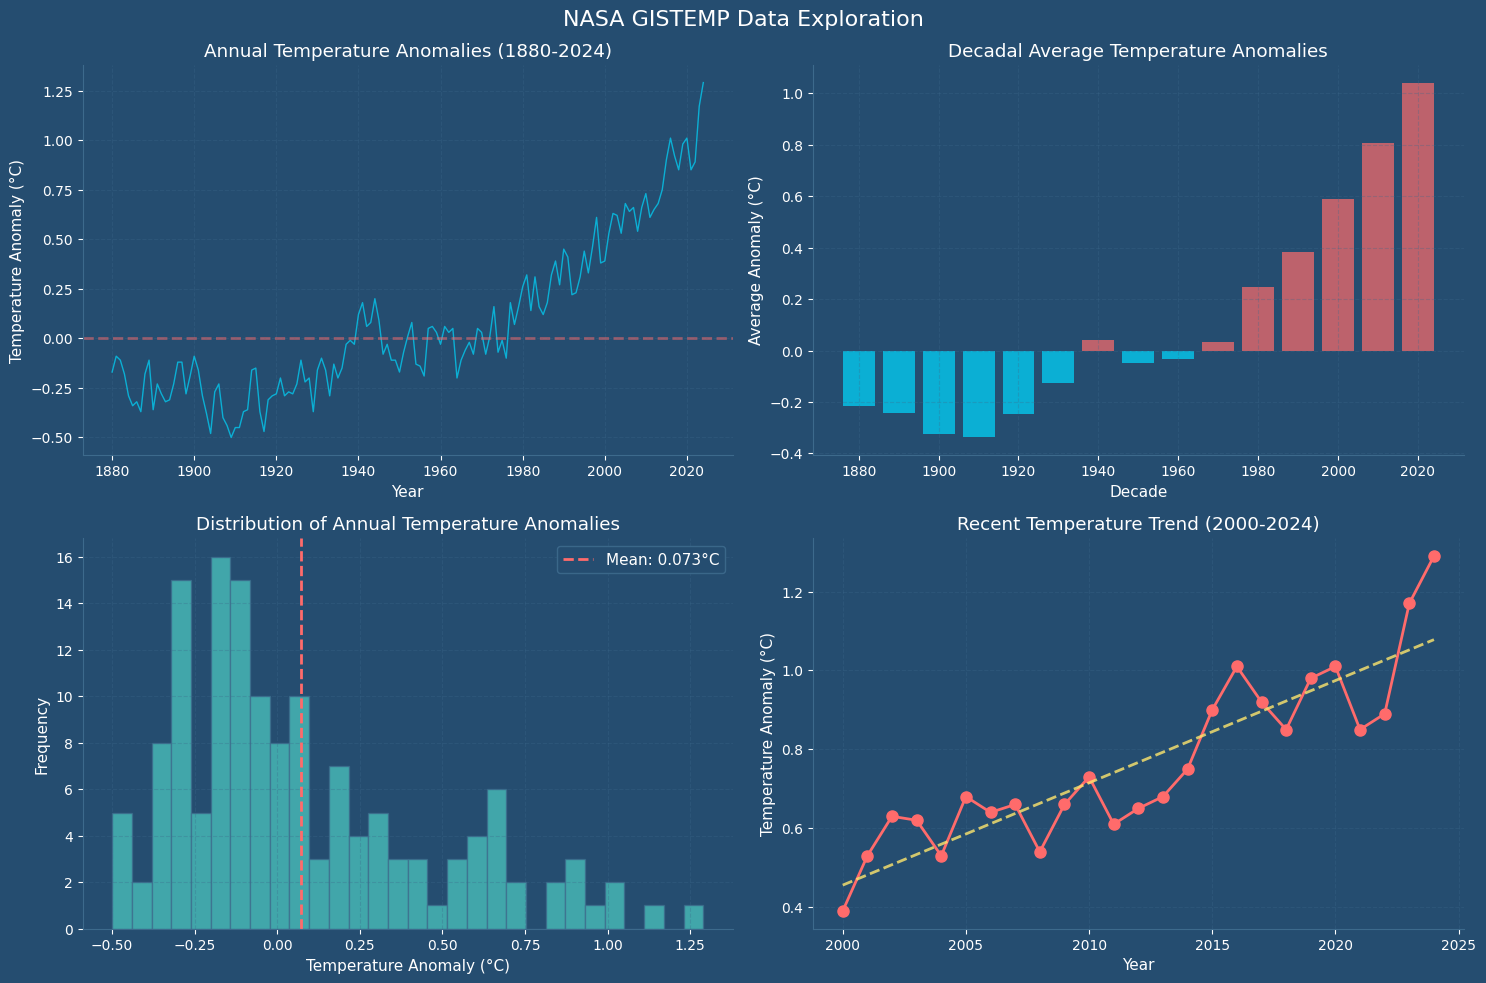

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('NASA GISTEMP Data Exploration', fontsize=16, color=COLORS['text'], y=0.98)

# time series plot
ax1 = axes[0, 0]
valid_data = df[df['J-D_numeric'].notna()]
ax1.plot(valid_data['Year'], valid_data['J-D_numeric'], color=COLORS['primary'], alpha=0.7, linewidth=1)
ax1.axhline(y=0, color=COLORS['secondary'], linestyle='--', alpha=0.5)
ax1.set_xlabel('Year', color=COLORS['text'])
ax1.set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax1.set_title('Annual Temperature Anomalies (1880-2024)', color=COLORS['text'])
ax1.grid(True, alpha=0.3, color=COLORS['grid'])

# decadal bar chart
ax2 = axes[0, 1]
decades = decadal_avg.index
means = decadal_avg['mean']
colors = [COLORS['secondary'] if x > 0 else COLORS['primary'] for x in means]
ax2.bar(decades, means, width=8, color=colors, alpha=0.7)
ax2.set_xlabel('Decade', color=COLORS['text'])
ax2.set_ylabel('Average Anomaly (°C)', color=COLORS['text'])
ax2.set_title('Decadal Average Temperature Anomalies', color=COLORS['text'])
ax2.grid(True, alpha=0.3, color=COLORS['grid'])

# histogram
ax3 = axes[1, 0]
ax3.hist(valid_data['J-D_numeric'], bins=30, color=COLORS['accent1'], alpha=0.7, edgecolor=COLORS['grid'])
ax3.axvline(valid_data['J-D_numeric'].mean(), color=COLORS['secondary'], linestyle='--', 
            label=f'Mean: {valid_data["J-D_numeric"].mean():.3f}°C')
ax3.set_xlabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax3.set_ylabel('Frequency', color=COLORS['text'])
ax3.set_title('Distribution of Annual Temperature Anomalies', color=COLORS['text'])
ax3.legend(labelcolor=COLORS['text'])
ax3.grid(True, alpha=0.3, color=COLORS['grid'])

# recent acceleration
ax4 = axes[1, 1]
recent_years = df[df['Year'] >= 2000].copy()
recent_valid = recent_years[recent_years['J-D_numeric'].notna()]
ax4.plot(recent_valid['Year'], recent_valid['J-D_numeric'], color=COLORS['secondary'], 
         marker='o', markersize=8, linewidth=2)

# trend line
z = np.polyfit(recent_valid['Year'], recent_valid['J-D_numeric'], 1)
p = np.poly1d(z)
ax4.plot(recent_valid['Year'], p(recent_valid['Year']), color=COLORS['accent2'], 
         linestyle='--', alpha=0.8, linewidth=2)

ax4.set_xlabel('Year', color=COLORS['text'])
ax4.set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax4.set_title('Recent Temperature Trend (2000-2024)', color=COLORS['text'])
ax4.grid(True, alpha=0.3, color=COLORS['grid'])

for ax in axes.flat:
    style_axis(ax)

plt.tight_layout()
plt.show()

## Data Preparation & Cleaning

In [139]:
df = df.replace('***', np.nan)

# convert all numeric columns to float
numeric_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                    'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']
    
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
print(f"\n Data loaded: {len(df)} years")
print(f"\n Missing values replaced with NaN")
print(f"\n Numeric columns converted")


 Data loaded: 146 years

 Missing values replaced with NaN

 Numeric columns converted


In [138]:
# monthly time series creation
# select only year and monthly columns
monthly_cols = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_monthly = df[monthly_cols].copy()

# 'melt' the dataframe to long format
df_long = df_monthly.melt(id_vars=['Year'], 
                         var_name='Month', 
                         value_name='Temperature_Anomaly')

# proper datetime index
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
             'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df_long['Month_Num'] = df_long['Month'].map(month_map)
df_long['Day'] = 1
df_long['Date'] = pd.to_datetime(df_long[['Year', 'Month_Num', 'Day']].rename(columns={'Month_Num': 'month', 'Year': 'year', 'Day': 'day'}))
    
# sort by date and set index
df_long = df_long.sort_values('Date')
df_long = df_long.set_index('Date')
    
# keep only the temperature anomaly column
monthly_ts = df_long['Temperature_Anomaly'].copy()

print(f"\nMonthly time series created")
print(f"  - Date range: {monthly_ts.index.min()} to {monthly_ts.index.max()}")
print(f"  - Total points: {len(monthly_ts)}")
print(f"  - Missing values: {monthly_ts.isna().sum()} ({monthly_ts.isna().sum()/len(monthly_ts)*100:.1f}%)")


Monthly time series created
  - Date range: 1880-01-01 00:00:00 to 2025-12-01 00:00:00
  - Total points: 1752
  - Missing values: 0 (0.0%)


In [137]:
# create annual series
annual_ts = pd.Series(
    data=df['J-D'].values,
    index=pd.to_datetime(df['Year'], format='%Y'),
    name='Annual_Temperature_Anomaly'
)
    
# remove NaNs
annual_ts_clean = annual_ts.dropna()
    
print(f"\nAnnual time series created")
print(f"  - Date range: {annual_ts.index.min().year} to {annual_ts.index.max().year}")
print(f"  - Total points: {len(annual_ts)}")
print(f"  - Valid points: {len(annual_ts_clean)} ({len(annual_ts_clean)/len(annual_ts)*100:.1f}%)")


Annual time series created
  - Date range: 1880 to 2025
  - Total points: 146
  - Valid points: 146 (100.0%)


In [82]:
# monthly missing data
monthly_missing = monthly_ts[monthly_ts.isna()]
    
if len(monthly_missing) > 0:
    print(f"\nMonthly missing data points:")
    for date in monthly_missing.index[:10]:
        print(f"  - {date.strftime('%Y-%m')}")
    if len(monthly_missing) > 10:
        print(f"  ... and {len(monthly_missing)-10} more")
    
if len(monthly_missing) > 0:
    last_missing_year = monthly_missing.index[-1].year
    current_year_missing = monthly_missing[monthly_missing.index.year == last_missing_year]
    print(f"\nMissing data in {last_missing_year}: {len(current_year_missing)} months")


Monthly missing data points:
  - 2025-05
  - 2025-06
  - 2025-07
  - 2025-08
  - 2025-09
  - 2025-10
  - 2025-11
  - 2025-12

Missing data in 2025: 8 months


In [135]:
seasonal_data = {}
    
# winter (DJF)
seasonal_data['Winter'] = pd.Series(
    data=df['DJF'].values,
    index=pd.to_datetime(df['Year'], format='%Y'),
    name='Winter_DJF'
).dropna()

# spring (MAM)
seasonal_data['Spring'] = pd.Series(
    data=df['MAM'].values,
    index=pd.to_datetime(df['Year'], format='%Y'),
    name='Spring_MAM'
).dropna()

# summer (JJA)
seasonal_data['Summer'] = pd.Series(
    data=df['JJA'].values,
    index=pd.to_datetime(df['Year'], format='%Y'),
    name='Summer_JJA'
).dropna()

# fall (SON)
seasonal_data['Fall'] = pd.Series(
    data=df['SON'].values,
    index=pd.to_datetime(df['Year'], format='%Y'),
    name='Fall_SON'
).dropna()

print("\nSeasonal time series created:")
for season, ts in seasonal_data.items():
    print(f"  - {season}: {len(ts)} valid points")


Seasonal time series created:
  - Winter: 146 valid points
  - Spring: 146 valid points
  - Summer: 146 valid points
  - Fall: 146 valid points


In [141]:
# save time series
monthly_ts.to_csv('data/monthly_temperature_ts.csv', header=True)
print("-    Monthly time series saved to: monthly_temperature_ts.csv")

annual_ts.to_csv('data/annual_temperature_ts.csv', header=True)
print("-    Annual time series saved to: annual_temperature_ts.csv")

seasonal_df = pd.DataFrame(seasonal_data)
seasonal_df.to_csv('data/seasonal_temperature_ts.csv')
print("-    Seasonal time series saved to: seasonal_temperature_ts.csv")

df_long.to_csv('data/temperature_data_long_format.csv')
print("-    Long format data saved to: temperature_data_long_format.csv")

-    Monthly time series saved to: monthly_temperature_ts.csv
-    Annual time series saved to: annual_temperature_ts.csv
-    Seasonal time series saved to: seasonal_temperature_ts.csv
-    Long format data saved to: temperature_data_long_format.csv


In [85]:
print("\nMonthly Time Series:")
print(f"  - Total months: {len(monthly_ts)}")
print(f"  - Date range: {monthly_ts.index.min().strftime('%Y-%m')} to {monthly_ts.index.max().strftime('%Y-%m')}")
print(f"  - Missing values: {monthly_ts.isna().sum()}")
print(f"  - Mean: {monthly_ts.mean():.3f}°C")
print(f"  - Std Dev: {monthly_ts.std():.3f}°C")

print("\nAnnual Time Series:")
print(f"  - Total years: {len(annual_ts)}")
print(f"  - Date range: {annual_ts.index.min().year} to {annual_ts.index.max().year}")
print(f"  - Complete years: {annual_ts.notna().sum()}")
print(f"  - Mean: {annual_ts.mean():.3f}°C")
print(f"  - Std Dev: {annual_ts.std():.3f}°C")


Monthly Time Series:
  - Total months: 1752
  - Date range: 1880-01 to 2025-12
  - Missing values: 8
  - Mean: 0.076°C
  - Std Dev: 0.411°C

Annual Time Series:
  - Total years: 146
  - Date range: 1880 to 2025
  - Complete years: 145
  - Mean: 0.073°C
  - Std Dev: 0.394°C


## Time Series Exploration

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [142]:
monthly_data = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for _, row in df.iterrows():
    for i, month in enumerate(months):
        if pd.notna(row[month]):
            date = pd.Timestamp(year=int(row['Year']), month=i+1, day=1)
            monthly_data.append({
                'date': date,
                'value': row[month],
                'month': month,
                'month_num': i+1,
                'year': row['Year']
            })

monthly_df = pd.DataFrame(monthly_data)
monthly_ts = monthly_df.set_index('date')['value'].sort_index()

# annual time series
annual_ts = pd.Series(
    data=df['J-D'].values,
    index=pd.to_datetime(df['Year'], format='%Y'),
    name='annual_temp_anomaly'
).dropna()

In [88]:
# detect outliers using IQR
Q1 = monthly_ts.quantile(0.25)
Q3 = monthly_ts.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
bounds = [lower_bound, upper_bound]

outliers = monthly_ts[(monthly_ts < lower_bound) | (monthly_ts > upper_bound)]
print(f"\nOutliers (IQR method):")
print(f"  Lower bound: {lower_bound:.3f}°C")
print(f"  Upper bound: {upper_bound:.3f}°C")
print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(monthly_ts)*100:.1f}%)")

# extreme values
print(f"\nExtreme values:")
print(f"  5 Highest: ")
for date, val in monthly_ts.nlargest(5).items():
    print(f"    {date.strftime('%Y-%m')}: {val:.2f}°C")

print(f"  5 Lowest: ")
for date, val in monthly_ts.nsmallest(5).items():
    print(f"    {date.strftime('%Y-%m')}: {val:.2f}°C")


Outliers (IQR method):
  Lower bound: -1.000°C
  Upper bound: 1.080°C
  Number of outliers: 37 (2.1%)

Extreme values:
  5 Highest: 
    2023-09: 1.48°C
    2024-02: 1.44°C
    2023-11: 1.42°C
    2024-03: 1.39°C
    2016-02: 1.37°C
  5 Lowest: 
    1916-12: -0.82°C
    1893-01: -0.81°C
    1909-01: -0.74°C
    1887-01: -0.72°C
    1917-12: -0.69°C


In [89]:
# calculate monthly averages
monthly_avg = monthly_df.groupby('month')['value'].agg(['mean', 'std', 'count'])
monthly_avg = monthly_avg.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

print("\nAverage temperature anomaly by month:")
for month, row in monthly_avg.iterrows():
    print(f"  {month}: {row['mean']:>6.3f}°C (±{row['std']:.3f})")

# seasonal averages
monthly_df['season'] = monthly_df['month_num'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

seasonal_avg = monthly_df.groupby('season')['value'].agg(['mean', 'std'])
print("\nSeasonal averages:")
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in seasonal_avg.index:
        row = seasonal_avg.loc[season]
        print(f"  {season}: {row['mean']:>6.3f}°C (±{row['std']:.3f})")


Average temperature anomaly by month:
  Jan:  0.077°C (±0.447)
  Feb:  0.085°C (±0.452)
  Mar:  0.103°C (±0.459)
  Apr:  0.076°C (±0.421)
  May:  0.057°C (±0.390)
  Jun:  0.045°C (±0.390)
  Jul:  0.069°C (±0.372)
  Aug:  0.068°C (±0.388)
  Sep:  0.073°C (±0.390)
  Oct:  0.098°C (±0.395)
  Nov:  0.091°C (±0.404)
  Dec:  0.066°C (±0.420)

Seasonal averages:
  Winter:  0.076°C (±0.439)
  Spring:  0.078°C (±0.424)
  Summer:  0.061°C (±0.383)
  Fall:  0.087°C (±0.396)


In [90]:
# linear trend for annual data
years = np.arange(len(annual_ts))
slope, intercept, r_value, p_value, std_err = stats.linregress(years, annual_ts.values)

print(f"\nLinear trend (annual data):")
print(f"  Slope: {slope:.4f}°C/year")
print(f"  Total change (1880-2024): {slope * (2024-1880):.2f}°C")
print(f"  R-squared: {r_value**2:.3f}")
print(f"  P-value: {p_value:.2e}")

# decadal rate of change
decadal_changes = []
decades = range(1880, 2030, 10)

for i in range(len(decades)-1):
    decade_start = decades[i]
    decade_end = decades[i+1]
    
    start_data = annual_ts[(annual_ts.index.year >= decade_start) & 
                            (annual_ts.index.year < decade_start+10)]
    end_data = annual_ts[(annual_ts.index.year >= decade_end) & 
                        (annual_ts.index.year < decade_end+10)]
    
    if len(start_data) > 0 and len(end_data) > 0:
        change = end_data.mean() - start_data.mean()
        decadal_changes.append({
            'decade': f"{decade_start}s-{decade_end}s",
            'change': change
        })

print("\nDecadal rate of change:")
for item in decadal_changes[-5:]:
    print(f"  {item['decade']}: {item['change']:>+.3f}°C")


Linear trend (annual data):
  Slope: 0.0082°C/year
  Total change (1880-2024): 1.18°C
  R-squared: 0.766
  P-value: 6.98e-47

Decadal rate of change:
  1970s-1980s: +0.212°C
  1980s-1990s: +0.137°C
  1990s-2000s: +0.204°C
  2000s-2010s: +0.220°C
  2010s-2020s: +0.234°C


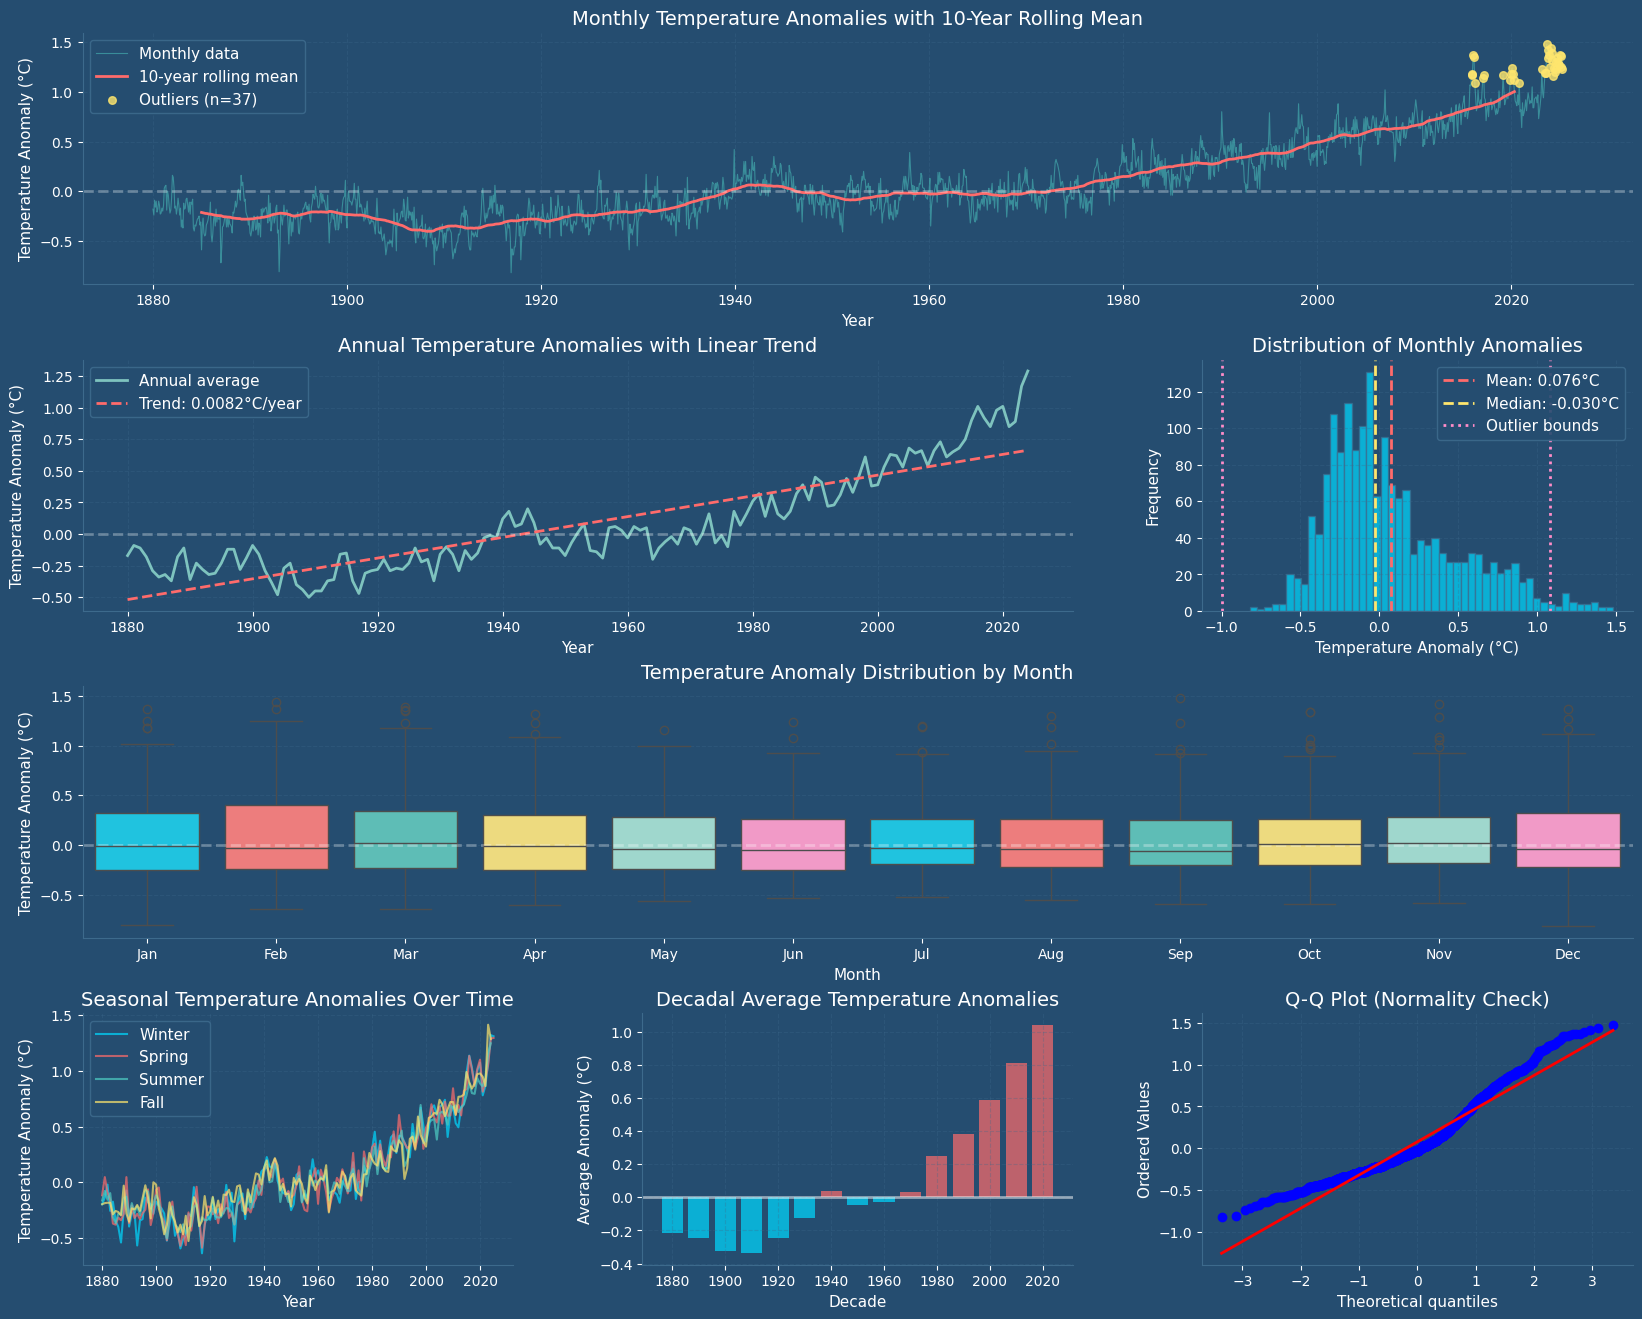

In [ ]:
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# monthly time series with trend
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(monthly_ts.index, monthly_ts.values, color=COLORS['accent1'], alpha=0.5, linewidth=0.8, label='Monthly data')

# rolling mean
rolling_mean = monthly_ts.rolling(window=120, center=True).mean()
ax1.plot(rolling_mean.index, rolling_mean.values, color=COLORS['secondary'], linewidth=2, label='10-year rolling mean')

# outliers
ax1.scatter(outliers.index, outliers.values, color=COLORS['accent2'], s=30, alpha=0.8, 
            label=f'Outliers (n={len(outliers)})', zorder=5)

ax1.axhline(y=0, color=COLORS['text'], linestyle='--', alpha=0.3)
ax1.set_title('Monthly Temperature Anomalies with 10-Year Rolling Mean', fontsize=14, color=COLORS['text'])
ax1.set_xlabel('Year', color=COLORS['text'])
ax1.set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax1.legend()
ax1.grid(True, alpha=0.3, color=COLORS['grid'])

# annual time series with trend line
ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(annual_ts.index, annual_ts.values, color=COLORS['accent3'], linewidth=2, alpha=0.8, label='Annual average')

# trend line
years = np.arange(len(annual_ts))
slope, intercept, _, _, _ = stats.linregress(years, annual_ts.values)
trend_line = slope * years + intercept
ax2.plot(annual_ts.index, trend_line, color=COLORS['secondary'], linestyle='--', linewidth=2, 
            label=f'Trend: {slope:.4f}°C/year')

ax2.axhline(y=0, color=COLORS['text'], linestyle='--', alpha=0.3)
ax2.set_title('Annual Temperature Anomalies with Linear Trend', fontsize=14, color=COLORS['text'])
ax2.set_xlabel('Year', color=COLORS['text'])
ax2.set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax2.legend()
ax2.grid(True, alpha=0.3, color=COLORS['grid'])

# distribution histogram
ax3 = fig.add_subplot(gs[1, 2])
ax3.hist(monthly_ts.dropna(), bins=50, color=COLORS['primary'], alpha=0.7, edgecolor=COLORS['grid'])
ax3.axvline(monthly_ts.mean(), color=COLORS['secondary'], linestyle='--', linewidth=2, label=f'Mean: {monthly_ts.mean():.3f}°C')
ax3.axvline(monthly_ts.median(), color=COLORS['accent2'], linestyle='--', linewidth=2, label=f'Median: {monthly_ts.median():.3f}°C')
ax3.axvline(bounds[0], color=COLORS['accent4'], linestyle=':', linewidth=2, label='Outlier bounds')
ax3.axvline(bounds[1], color=COLORS['accent4'], linestyle=':', linewidth=2)
ax3.set_title('Distribution of Monthly Anomalies', fontsize=14, color=COLORS['text'])
ax3.set_xlabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax3.set_ylabel('Frequency', color=COLORS['text'])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y', color=COLORS['grid'])

# box plot by month
ax4 = fig.add_subplot(gs[2, :])
monthly_df_sorted = monthly_df.copy()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_df_sorted['month'] = pd.Categorical(monthly_df_sorted['month'], 
                                            categories=month_order, 
                                            ordered=True)

box_plot = sns.boxplot(data=monthly_df_sorted, x='month', y='value', ax=ax4, palette=palette)
ax4.axhline(y=0, color=COLORS['text'], linestyle='--', alpha=0.3)
ax4.set_title('Temperature Anomaly Distribution by Month', fontsize=14, color=COLORS['text'])
ax4.set_xlabel('Month', color=COLORS['text'])
ax4.set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax4.grid(True, alpha=0.3, axis='y', color=COLORS['grid'])

# seasonal comparison
ax5 = fig.add_subplot(gs[3, 0])
seasonal_data = monthly_df.groupby(['year', 'season'])['value'].mean().reset_index()
for season, color in zip(['Winter', 'Spring', 'Summer', 'Fall'], palette):
    season_data = seasonal_data[seasonal_data['season'] == season]
    ax5.plot(season_data['year'], season_data['value'], label=season, color=color, alpha=0.7, linewidth=1.5)

ax5.set_title('Seasonal Temperature Anomalies Over Time', fontsize=14, color=COLORS['text'])
ax5.set_xlabel('Year', color=COLORS['text'])
ax5.set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
ax5.legend()
ax5.grid(True, alpha=0.3, color=COLORS['grid'])

# decadal averages bar plot
ax6 = fig.add_subplot(gs[3, 1])
decadal_data = annual_ts.groupby(annual_ts.index.year // 10 * 10).mean()
colors = [COLORS['primary'] if x < 0 else COLORS['secondary'] for x in decadal_data.values]
bars = ax6.bar(decadal_data.index, decadal_data.values, width=8, color=colors, alpha=0.7)
ax6.axhline(y=0, color=COLORS['text'], linestyle='-', alpha=0.5)
ax6.set_title('Decadal Average Temperature Anomalies', fontsize=14, color=COLORS['text'])
ax6.set_xlabel('Decade', color=COLORS['text'])
ax6.set_ylabel('Average Anomaly (°C)', color=COLORS['text'])
ax6.grid(True, alpha=0.3, axis='y', color=COLORS['grid'])

# Q-Q plot for normality check
ax7 = fig.add_subplot(gs[3, 2])
stats.probplot(monthly_ts.dropna(), dist="norm", plot=ax7)
ax7.set_title('Q-Q Plot (Normality Check)', fontsize=14, color=COLORS['text'])
ax7.grid(True, alpha=0.3, color=COLORS['grid'])

plt.tight_layout()
plt.show()

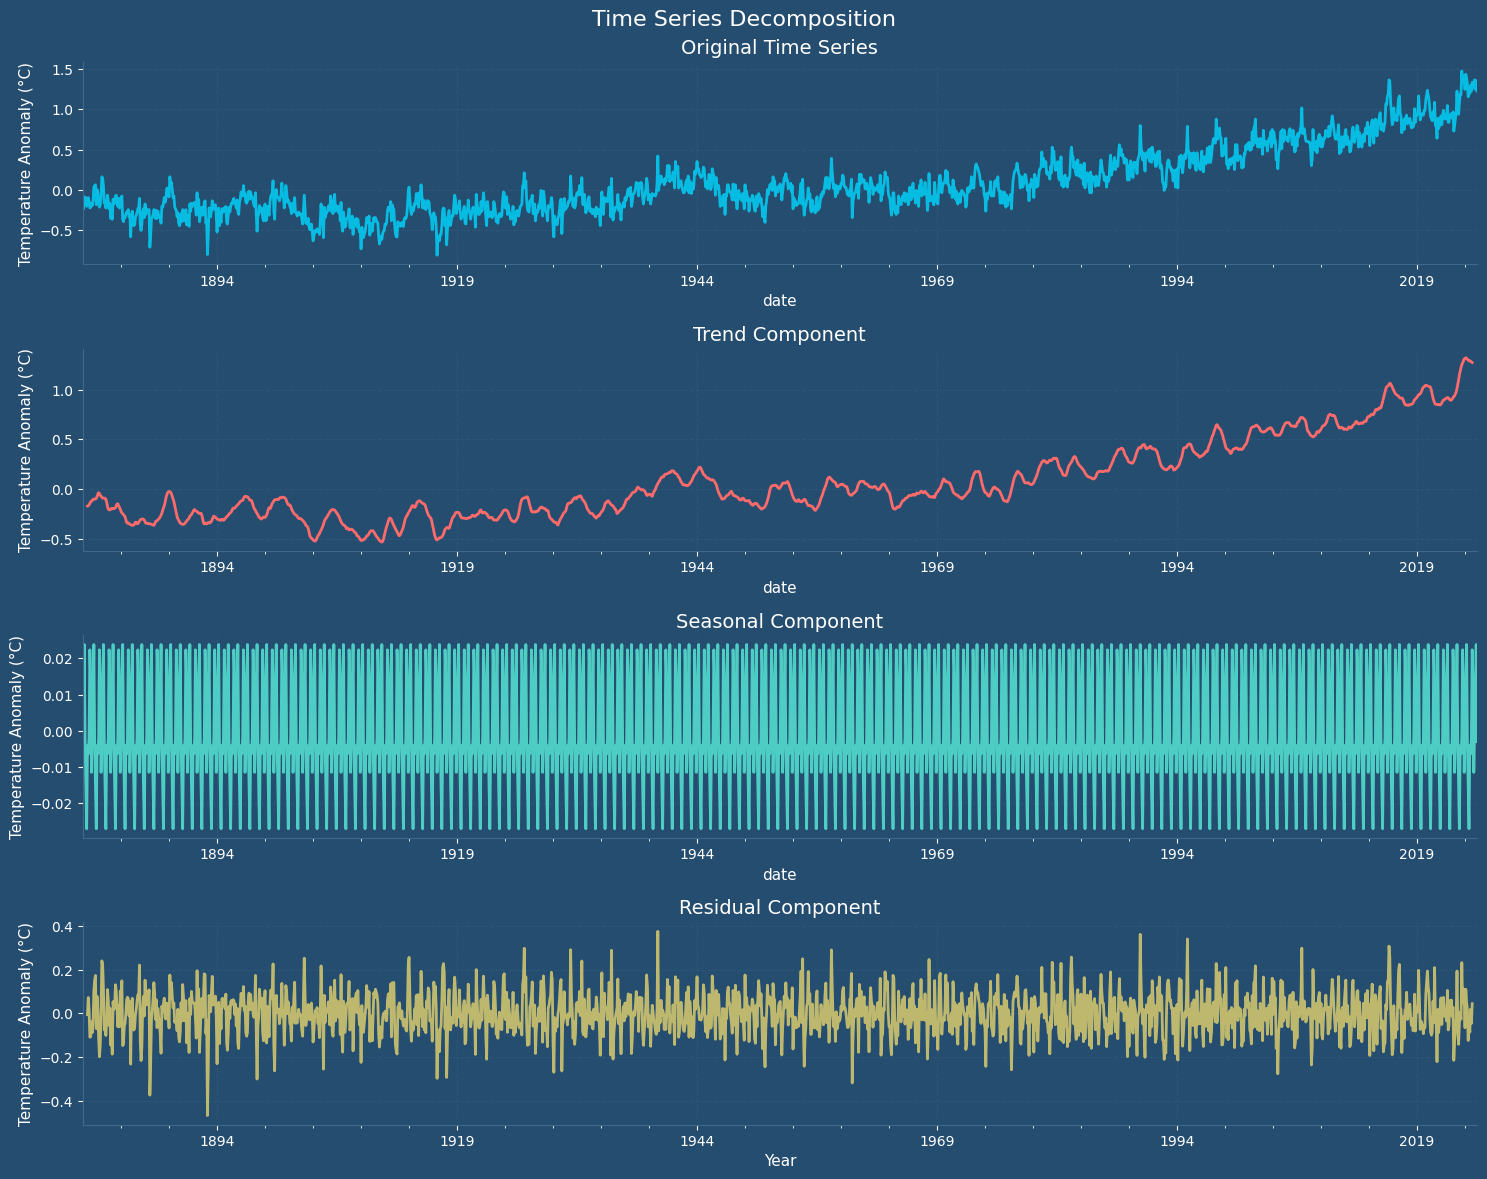


Decomposition Analysis:
  Strength of Trend: 0.945
  Strength of Seasonality: 0.023
  Seasonal range: -0.027 to 0.024°C


In [143]:
# ensure a complete time series for decomposition
# fill missing values with interpolation
monthly_ts_filled = monthly_ts.interpolate(method='linear')

# perform decomposition
decomposition = seasonal_decompose(monthly_ts_filled, model='additive', period=12)

# create decomposition plot with custom theme
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.patch.set_facecolor('#254D70')

# original series
monthly_ts_filled.plot(ax=axes[0], color=COLORS['primary'], alpha=0.8)
axes[0].set_title('Original Time Series', fontsize=14, color=COLORS['text'])
axes[0].set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
axes[0].grid(True, alpha=0.3, color=COLORS['grid'])
axes[0].tick_params(colors=COLORS['text'])

# trend
decomposition.trend.plot(ax=axes[1], color=COLORS['secondary'], linewidth=2)
axes[1].set_title('Trend Component', fontsize=14, color=COLORS['text'])
axes[1].set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
axes[1].grid(True, alpha=0.3, color=COLORS['grid'])
axes[1].tick_params(colors=COLORS['text'])

# seasonal
decomposition.seasonal.plot(ax=axes[2], color=COLORS['accent1'])
axes[2].set_title('Seasonal Component', fontsize=14, color=COLORS['text'])
axes[2].set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
axes[2].grid(True, alpha=0.3, color=COLORS['grid'])
axes[2].tick_params(colors=COLORS['text'])

# residual
decomposition.resid.plot(ax=axes[3], color=COLORS['accent2'], alpha=0.7)
axes[3].set_title('Residual Component', fontsize=14, color=COLORS['text'])
axes[3].set_ylabel('Temperature Anomaly (°C)', color=COLORS['text'])
axes[3].set_xlabel('Year', color=COLORS['text'])
axes[3].grid(True, alpha=0.3, color=COLORS['grid'])
axes[3].tick_params(colors=COLORS['text'])

plt.suptitle('Time Series Decomposition', fontsize=16, color=COLORS['text'])
plt.tight_layout()
plt.show()

# calculate strength of trend and seasonality
var_resid = np.var(decomposition.resid.dropna())
var_trend_resid = np.var(decomposition.trend.dropna() + decomposition.resid.dropna())
var_seasonal_resid = np.var(decomposition.seasonal.dropna() + decomposition.resid.dropna())

strength_trend = max(0, 1 - var_resid / var_trend_resid)
strength_seasonal = max(0, 1 - var_resid / var_seasonal_resid)

print(f"\nDecomposition Analysis:")
print(f"  Strength of Trend: {strength_trend:.3f}")
print(f"  Strength of Seasonality: {strength_seasonal:.3f}")
print(f"  Seasonal range: {decomposition.seasonal.min():.3f} to {decomposition.seasonal.max():.3f}°C")

## Time Series Analysis

In [93]:
from statsmodels.tsa.stattools import kpss, adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [145]:
df = pd.read_csv('data/GLB.Ts+dSST.csv')
df = df.replace('***', np.nan)

# convert numeric columns
numeric_cols = ['J-D']  # annual average
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# drop rows with NaN
df_clean = df.dropna(subset=['J-D'])

# create time series
ts = pd.Series(
    data=df_clean['J-D'].values,
    index=pd.to_datetime(df_clean['Year'], format='%Y'),
    name='Temperature_Anomaly'
)

print(f"\nData loaded successfully:")
print(f"-   Original rows: {len(df)}")
print(f"-   After dropping NaN: {len(df_clean)} ({len(df_clean)/len(df)*100:.1f}%)")
print(f"-   Time range: {ts.index.min().year} to {ts.index.max().year}")


Data loaded successfully:
-   Original rows: 146
-   After dropping NaN: 145 (99.3%)
-   Time range: 1880 to 2024


In [101]:
def perform_stationarity_tests(ts, title="Original Series"):
    """Perform ADF (Augmented Dickey-Fuller) test for stationarity"""
    print("\n" + "-"*40)
    print(f"STATIONARITY TESTS: {title}")
    print("-"*40)
    
    # ADF test
    adf_result = adfuller(ts, autolag='AIC')
    print(f"\nAugmented Dickey-Fuller Test:")
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    
    adf_stationary = adf_result[1] < 0.05
    print(f"  Result: {'Stationary' if adf_stationary else 'Non-stationary'} (at 5% level)")
    
    # conclusion
    if adf_stationary:
        conclusion = "Series is stationary"
    else:
        conclusion = "Series is non-stationary"
    
    print(f"\n{conclusion}")
    
    return adf_result, conclusion

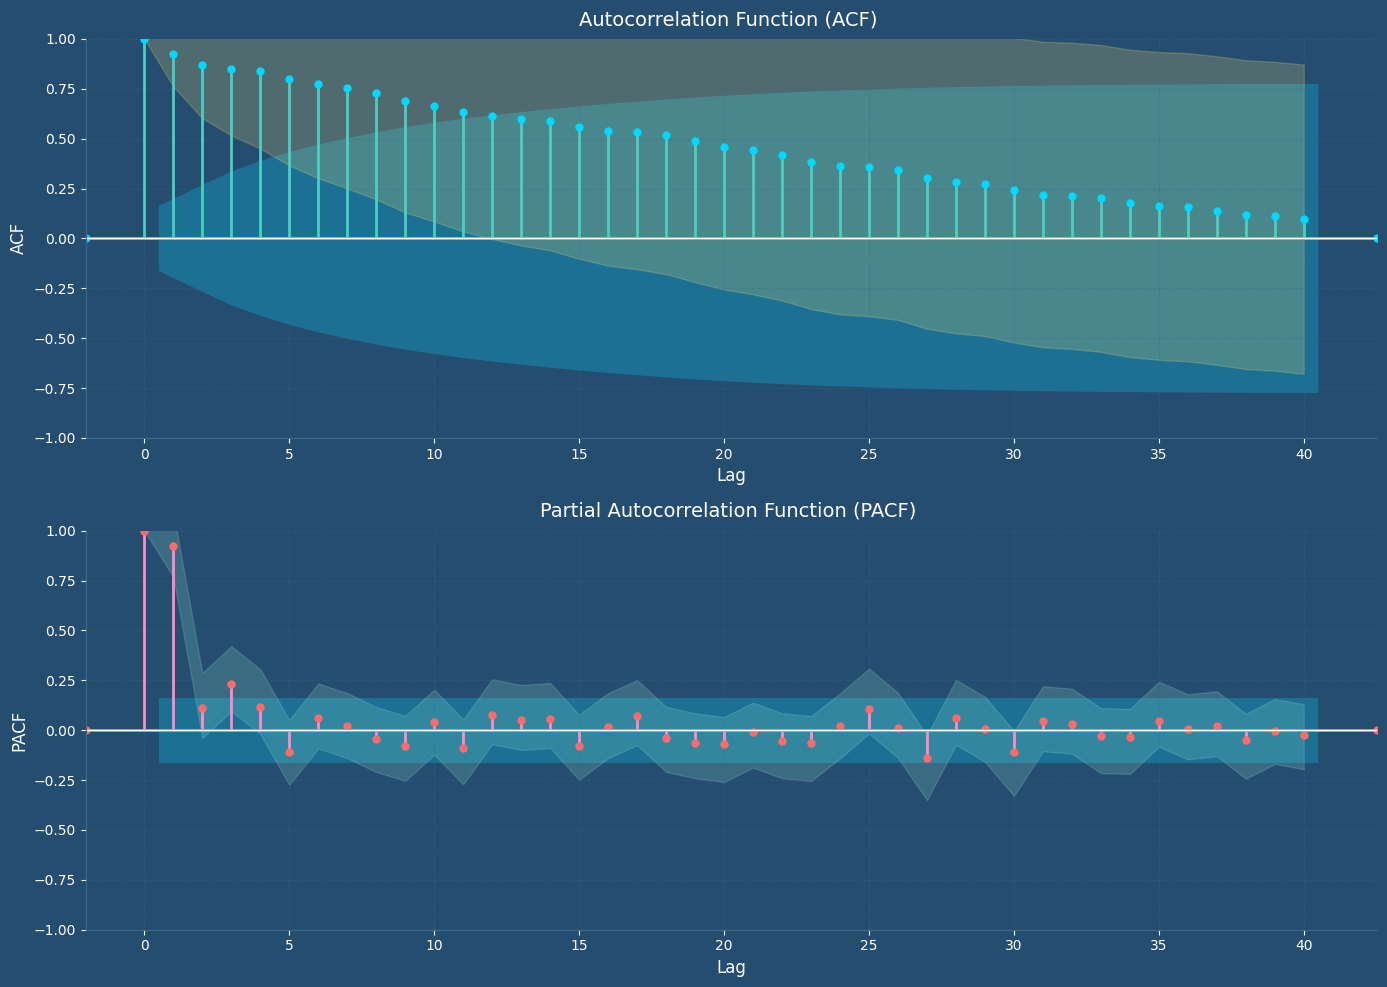

In [147]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.patch.set_facecolor('#254D70')

lags = 40
title_suffix = ''

# ACF plot
plot_acf(ts, lags=lags, ax=ax1, alpha=0.05, 
         color=COLORS['primary'], 
         vlines_kwargs={'colors': COLORS['accent1']},
         marker='o', markersize=5)
ax1.set_facecolor('#254D70')
ax1.axhline(y=0, color=COLORS['text'], linewidth=1)
style_axis(ax1, xlabel='Lag', ylabel='ACF', title=f'Autocorrelation Function (ACF) {title_suffix}')

# confidence bands for ACF
x = np.arange(lags + 1)
acf_values, confint_acf = acf(ts, nlags=lags, alpha=0.05)
ax1.fill_between(x, confint_acf[:, 0], confint_acf[:, 1], color=COLORS['accent2'], alpha=0.2)

# PACF plot
plot_pacf(ts, lags=lags, ax=ax2, alpha=0.05,
          color=COLORS['secondary'],
          vlines_kwargs={'colors': COLORS['accent4']},
          marker='o', markersize=5)
ax2.set_facecolor('#254D70')
ax2.axhline(y=0, color=COLORS['text'], linewidth=1)
style_axis(ax2, xlabel='Lag', ylabel='PACF', title=f'Partial Autocorrelation Function (PACF) {title_suffix}')

# confidence bands for PACF
pacf_values, confint_pacf = pacf(ts, nlags=lags, alpha=0.05)
ax2.fill_between(x, confint_pacf[:, 0], confint_pacf[:, 1], color=COLORS['accent3'], alpha=0.2)

plt.tight_layout()
plt.show()

In [148]:
print("\nTesting original series:")
adf_orig, conclusion_orig = perform_stationarity_tests(ts, "Original Series")

# first differencing
ts_diff1 = ts.diff().dropna()
print("\nTesting first differenced series:")
adf_diff1, conclusion_diff1 = perform_stationarity_tests(ts_diff1, "First Differenced")


Testing original series:

----------------------------------------
STATIONARITY TESTS: Original Series
----------------------------------------

Augmented Dickey-Fuller Test:
  ADF Statistic: 1.8096
  p-value: 0.9984
  Critical Values:
    1%: -3.4783
    5%: -2.8826
    10%: -2.5780
  Result: Non-stationary (at 5% level)

Series is non-stationary

Testing first differenced series:

----------------------------------------
STATIONARITY TESTS: First Differenced
----------------------------------------

Augmented Dickey-Fuller Test:
  ADF Statistic: -7.3605
  p-value: 0.0000
  Critical Values:
    1%: -3.4783
    5%: -2.8826
    10%: -2.5780
  Result: Stationary (at 5% level)

Series is stationary


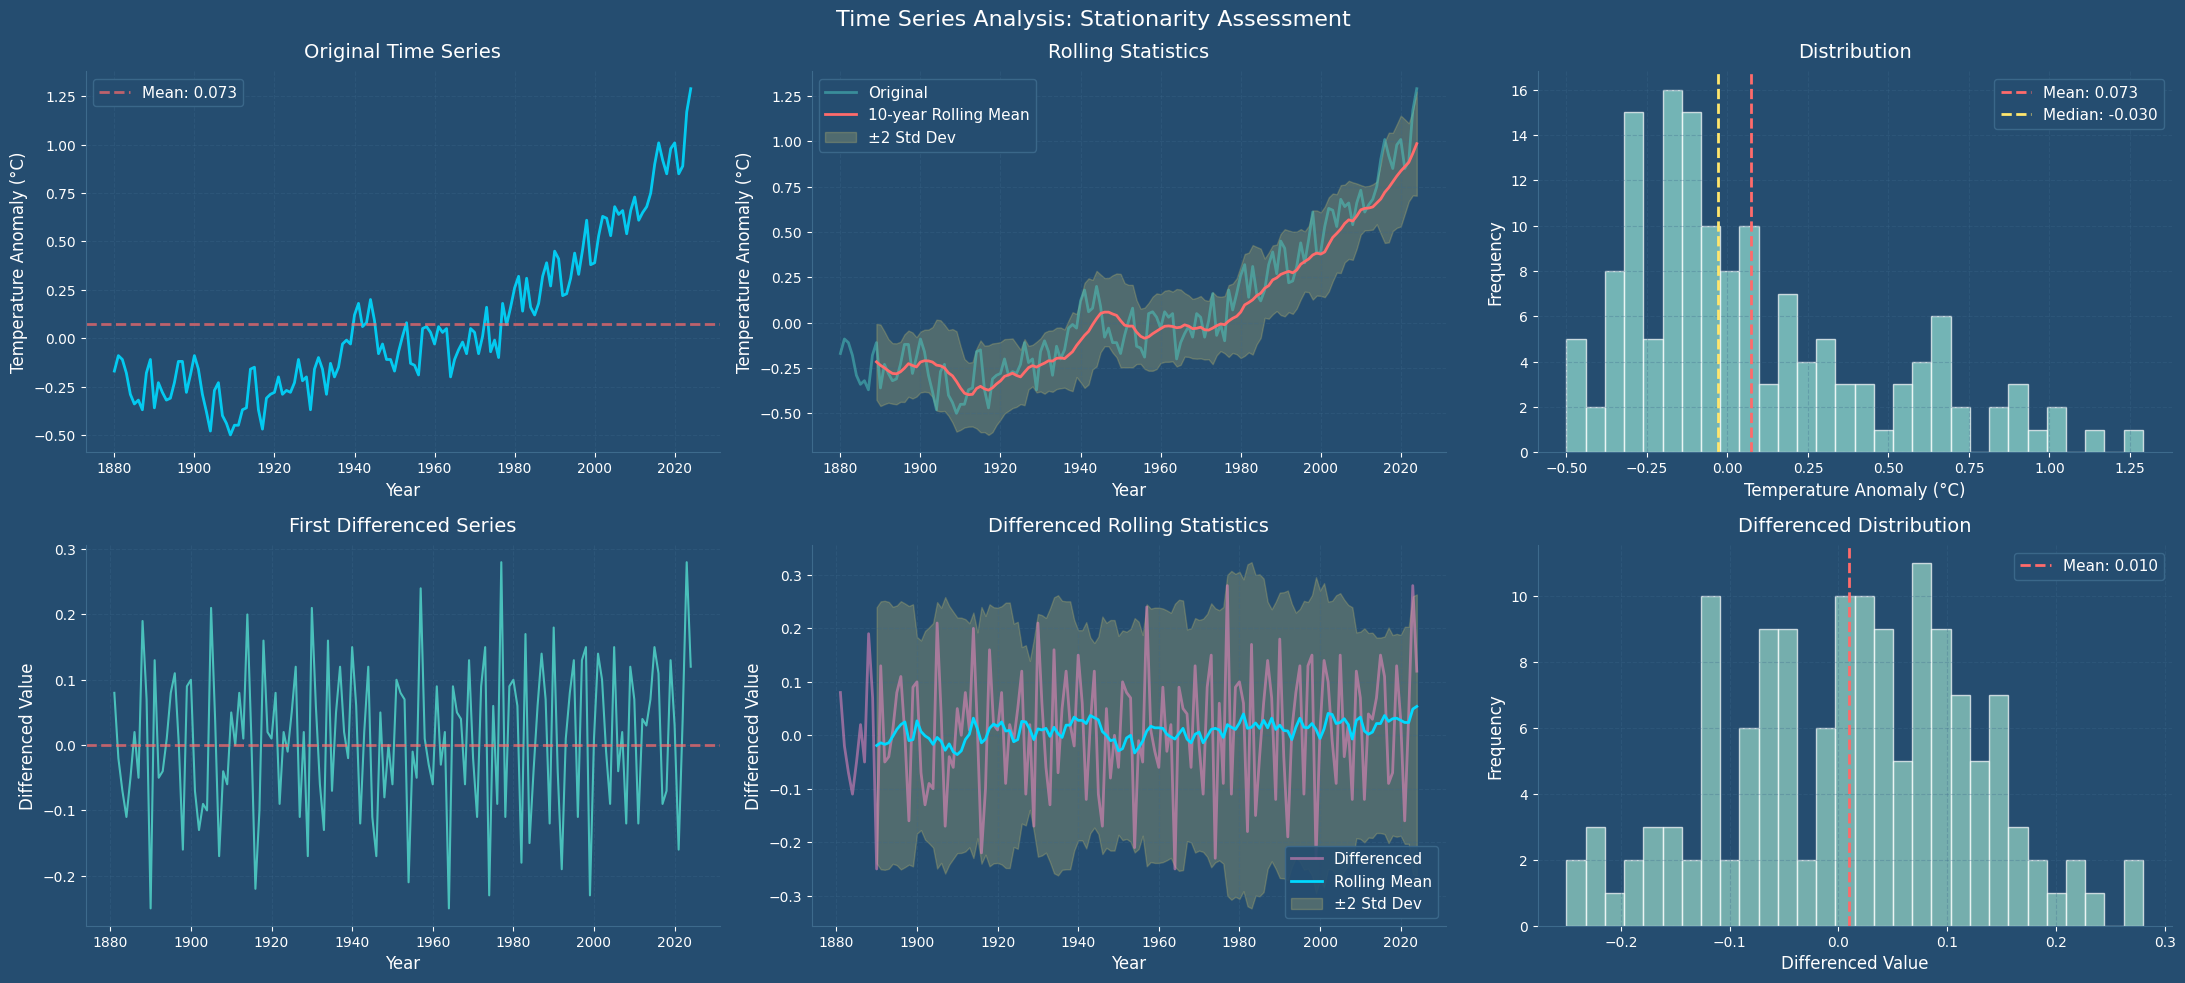

In [150]:
differenced_ts= ts_diff1

if differenced_ts is not None:
    fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    fig.patch.set_facecolor('#254D70')
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.patch.set_facecolor('#254D70')
    axes = axes.reshape(1, -1)

# original series
ax = axes[0, 0]
ax.plot(ts.index, ts.values, color=COLORS['primary'], linewidth=2, alpha=0.9)
ax.axhline(y=ts.mean(), color=COLORS['secondary'], linestyle='--', alpha=0.7, label=f'Mean: {ts.mean():.3f}')
style_axis(ax, xlabel='Year', ylabel='Temperature Anomaly (°C)', title='Original Time Series')
ax.legend()

# roling statistics
ax = axes[0, 1]
rolling_mean = ts.rolling(window=10).mean()
rolling_std = ts.rolling(window=10).std()
ax.plot(ts.index, ts.values, color=COLORS['accent1'], alpha=0.5, label='Original')
ax.plot(rolling_mean.index, rolling_mean.values, color=COLORS['secondary'], linewidth=2, label='10-year Rolling Mean')
ax.fill_between(rolling_std.index, 
                rolling_mean - 2*rolling_std, 
                rolling_mean + 2*rolling_std, 
                color=COLORS['accent2'], alpha=0.2, label='±2 Std Dev')
style_axis(ax, xlabel='Year', ylabel='Temperature Anomaly (°C)', title='Rolling Statistics')
ax.legend()

# distribution
ax = axes[0, 2]
ax.hist(ts.values, bins=30, color=COLORS['accent3'], alpha=0.7, edgecolor=COLORS['text'])
ax.axvline(ts.mean(), color=COLORS['secondary'], linestyle='--', linewidth=2, label=f'Mean: {ts.mean():.3f}')
ax.axvline(ts.median(), color=COLORS['accent2'], linestyle='--', linewidth=2, label=f'Median: {ts.median():.3f}')
style_axis(ax, xlabel='Temperature Anomaly (°C)', ylabel='Frequency', title='Distribution')
ax.legend()

# plot differenced series provided
if differenced_ts is not None:
    # differenced series
    ax = axes[1, 0]
    ax.plot(differenced_ts.index, differenced_ts.values, color=COLORS['accent1'], linewidth=1.5, alpha=0.9)
    ax.axhline(y=0, color=COLORS['secondary'], linestyle='--', alpha=0.7)
    style_axis(ax, xlabel='Year', ylabel='Differenced Value', title='First Differenced Series')
    
    # differenced rolling statistics
    ax = axes[1, 1]
    diff_rolling_mean = differenced_ts.rolling(window=10).mean()
    diff_rolling_std = differenced_ts.rolling(window=10).std()
    ax.plot(differenced_ts.index, differenced_ts.values, color=COLORS['accent4'], alpha=0.5, label='Differenced')
    ax.plot(diff_rolling_mean.index, diff_rolling_mean.values, color=COLORS['primary'], linewidth=2, label='Rolling Mean')
    ax.fill_between(diff_rolling_std.index, 
                    -2*diff_rolling_std, 
                    2*diff_rolling_std, 
                    color=COLORS['accent2'], alpha=0.2, label='±2 Std Dev')
    style_axis(ax, xlabel='Year', ylabel='Differenced Value', title='Differenced Rolling Statistics')
    ax.legend()
    
    # differenced distribution
    ax = axes[1, 2]
    ax.hist(differenced_ts.values, bins=30, color=COLORS['accent5'], alpha=0.7, edgecolor=COLORS['text'])
    ax.axvline(differenced_ts.mean(), color=COLORS['secondary'], linestyle='--', linewidth=2, 
                label=f'Mean: {differenced_ts.mean():.3f}')
    style_axis(ax, xlabel='Differenced Value', ylabel='Frequency', title='Differenced Distribution')
    ax.legend()

plt.suptitle('Time Series Analysis: Stationarity Assessment', fontsize=16, color=COLORS['text'], y=0.98)
plt.tight_layout()
plt.show()

## Model Selection

In [107]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

In [108]:
# reload data
df = pd.read_csv('data/GLB.Ts+dSST.csv')
df = df.replace('***', np.nan)
df['J-D'] = pd.to_numeric(df['J-D'], errors='coerce')
df_clean = df.dropna(subset=['J-D'])

# time series
ts = pd.Series(
    data=df_clean['J-D'].values,
    index=pd.to_datetime(df_clean['Year'], format='%Y'),
    name='Temperature_Anomaly'
)

print(f"\nData loaded: {len(ts)} years ({ts.index.min().year}-{ts.index.max().year})")

# train/test split
train_size = int(len(ts) * 0.85)
train = ts[:train_size]
test = ts[train_size:]

print(f"\nTrain/Test Split:")
print(f"-   Training set: {len(train)} years ({train.index.min().year}-{train.index.max().year})")
print(f"-   Test set: {len(test)} years ({test.index.min().year}-{test.index.max().year})")


Data loaded: 145 years (1880-2024)

Train/Test Split:
  Training set: 123 years (1880-2002)
  Test set: 22 years (2003-2024)


In [128]:
models_to_try = [
    (1, 1, 0),  # AR(1)
    (0, 1, 1),  # MA(1)
    (1, 1, 1),  # ARMA(1,1)
    (2, 1, 0),  # AR(2)
    (0, 1, 2),  # MA(2)
    (2, 1, 1),  # ARMA(2,1)
    (1, 1, 2),  # ARMA(1,2)
    (2, 1, 2),  # ARMA(2,2)
]

results = []

for order in models_to_try:
    try:
        print(f"\nFitting ARIMA{order}...")
        model = ARIMA(train, order=order)
        fitted = model.fit()
        
        # metrics
        aic = fitted.aic
        bic = fitted.bic
        loglik = fitted.llf
        
        # in-sample metrics
        residuals = fitted.resid
        mae = np.mean(np.abs(residuals))
        rmse = np.sqrt(np.mean(residuals**2))
        
        results.append({
            'order': order,
            'model': fitted,
            'aic': aic,
            'bic': bic,
            'loglik': loglik,
            'mae': mae,
            'rmse': rmse,
            'params': fitted.params
        })
        
        print(f"  AIC: {aic:.2f}, BIC: {bic:.2f}, MAE: {mae:.4f}")
        
    except Exception as e:
        print(f"  Failed to fit: {str(e)}")
        continue

# sort by AIC
results.sort(key=lambda x: x['aic'])


Fitting ARIMA(1, 1, 0)...
  AIC: -186.05, BIC: -180.44, MAE: 0.0929

Fitting ARIMA(0, 1, 1)...
  AIC: -193.76, BIC: -188.16, MAE: 0.0913

Fitting ARIMA(1, 1, 1)...
  AIC: -197.45, BIC: -189.04, MAE: 0.0893

Fitting ARIMA(2, 1, 0)...
  AIC: -193.45, BIC: -185.04, MAE: 0.0905

Fitting ARIMA(0, 1, 2)...
  AIC: -198.79, BIC: -190.38, MAE: 0.0889

Fitting ARIMA(2, 1, 1)...
  AIC: -197.64, BIC: -186.42, MAE: 0.0887

Fitting ARIMA(1, 1, 2)...
  AIC: -196.87, BIC: -185.65, MAE: 0.0889

Fitting ARIMA(2, 1, 2)...
  AIC: -194.81, BIC: -180.79, MAE: 0.0885


In [129]:
results_df = pd.DataFrame(results)
results_df

,order,model,aic,bic,loglik,mae,rmse,params
0,"(0, 1, 2)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-198.793190,-190.381127,102.396595,0.088945,0.105141,ma.L1 -0.369693 ma.L2 -0.222121 sigma2 ...
1,"(2, 1, 1)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-197.640281,-186.424197,102.820141,0.088737,0.104771,ar.L1 0.259603 ar.L2 -0.169620 ma.L1 ...
2,"(1, 1, 1)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-197.454873,-189.042809,101.727436,0.089297,0.105722,ar.L1 0.350216 ma.L1 -0.742558 sigma2 ...
3,"(1, 1, 2)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-196.866101,-185.650017,102.433050,0.088881,0.105112,ar.L1 0.071204 ma.L1 -0.432219 ma.L2 ...
4,"(2, 1, 2)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-194.810849,-180.790744,102.405425,0.088513,0.105146,ar.L1 -0.553591 ar.L2 0.374428 ma.L1 ...
5,"(0, 1, 1)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-193.763496,-188.155454,98.881748,0.091279,0.108174,ma.L1 -0.484912 sigma2 0.011549 dtype: f...
6,"(2, 1, 0)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-193.453691,-185.041628,99.726845,0.090465,0.107449,ar.L1 -0.278554 ar.L2 -0.273918 sigma2 ...
7,"(1, 1, 0)",<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,-186.045948,-180.437906,95.022974,0.092905,0.111640,ar.L1 -0.216189 sigma2 0.012325 dtype: f...


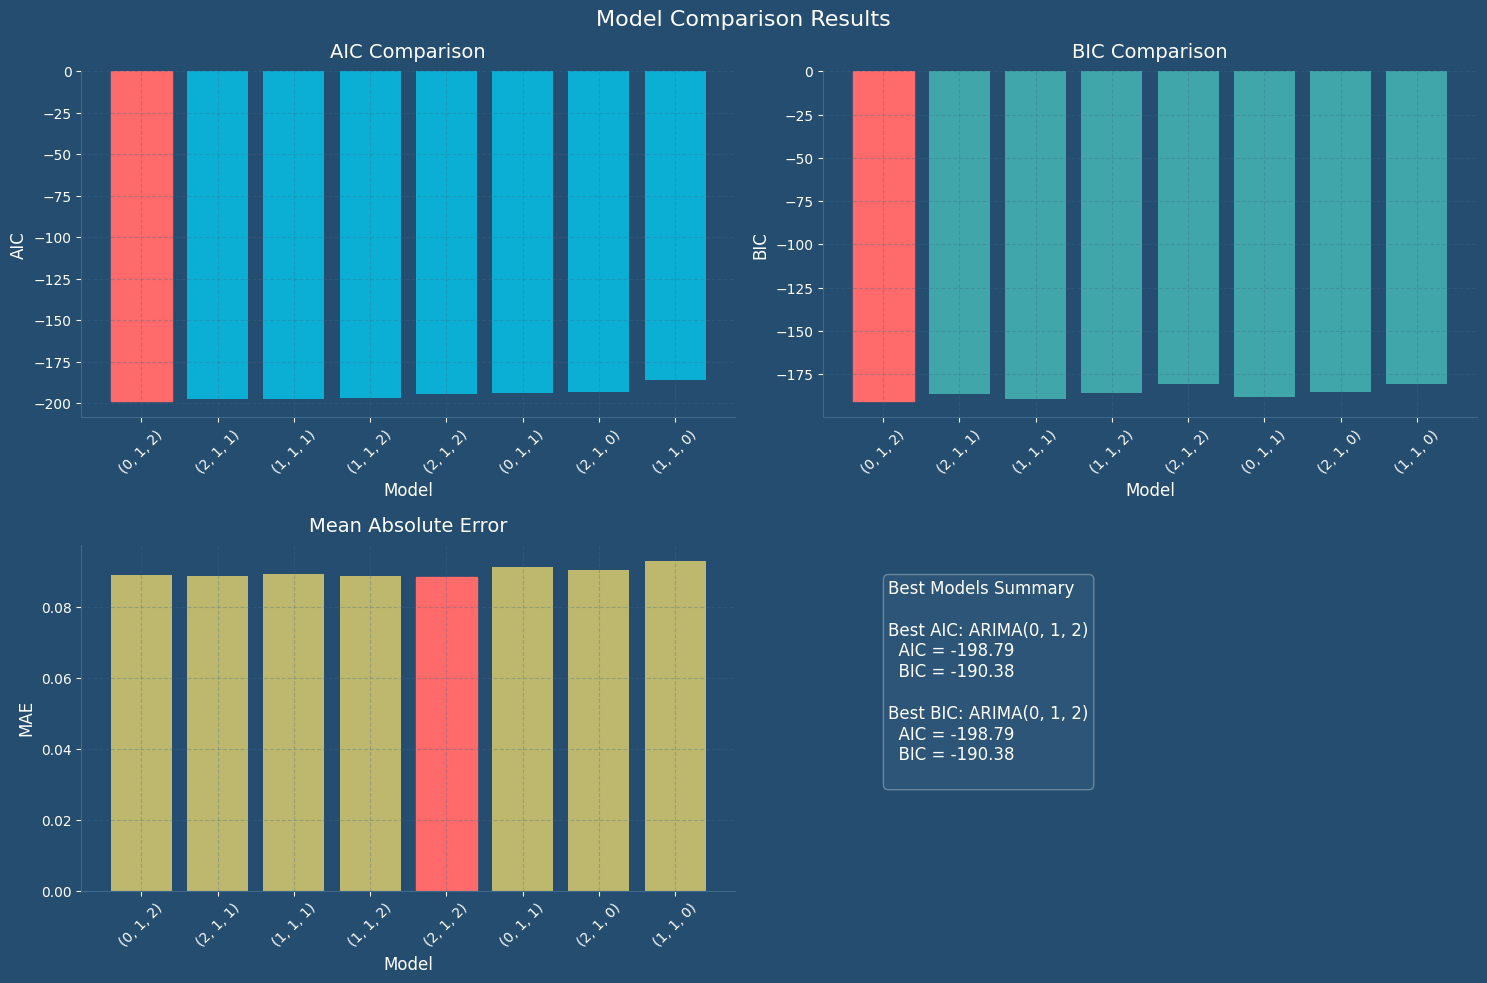

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.patch.set_facecolor('#254D70')

orders = [str(r['order']) for r in results]
aic_values = [r['aic'] for r in results]
bic_values = [r['bic'] for r in results]
mae_values = [r['mae'] for r in results]
rmse_values = [r['rmse'] for r in results]

# AIC comparison
ax = axes[0, 0]
bars = ax.bar(orders, aic_values, color=COLORS['primary'], alpha=0.7)
# highlight best model
min_idx = aic_values.index(min(aic_values))
bars[min_idx].set_color(COLORS['secondary'])
bars[min_idx].set_alpha(1.0)
style_axis(ax, xlabel='Model', ylabel='AIC', title='AIC Comparison')
ax.tick_params(axis='x', rotation=45)

# BIC comparison
ax = axes[0, 1]
bars = ax.bar(orders, bic_values, color=COLORS['accent1'], alpha=0.7)
min_idx = bic_values.index(min(bic_values))
bars[min_idx].set_color(COLORS['secondary'])
bars[min_idx].set_alpha(1.0)
style_axis(ax, xlabel='Model', ylabel='BIC', title='BIC Comparison')
ax.tick_params(axis='x', rotation=45)

# MAE comparison
ax = axes[1, 0]
bars = ax.bar(orders, mae_values, color=COLORS['accent2'], alpha=0.7)
min_idx = mae_values.index(min(mae_values))
bars[min_idx].set_color(COLORS['secondary'])
bars[min_idx].set_alpha(1.0)
style_axis(ax, xlabel='Model', ylabel='MAE', title='Mean Absolute Error')
ax.tick_params(axis='x', rotation=45)

ax = axes[1, 1]
ax.axis('off')

# summary
best_aic = results[0]  # sorted by AIC
best_bic = min(results, key=lambda x: x['bic'])

summary_text = f"Best Models Summary\n\n"
summary_text += f"Best AIC: ARIMA{best_aic['order']}\n"
summary_text += f"  AIC = {best_aic['aic']:.2f}\n"
summary_text += f"  BIC = {best_aic['bic']:.2f}\n\n"
summary_text += f"Best BIC: ARIMA{best_bic['order']}\n"
summary_text += f"  AIC = {best_bic['aic']:.2f}\n"
summary_text += f"  BIC = {best_bic['bic']:.2f}\n"

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
        fontsize=12, color=COLORS['text'], verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor=COLORS['grid'], alpha=0.3))

plt.suptitle('Model Comparison Results', fontsize=16, color=COLORS['text'])
plt.tight_layout()
plt.show()

## Model Evaluation & Results

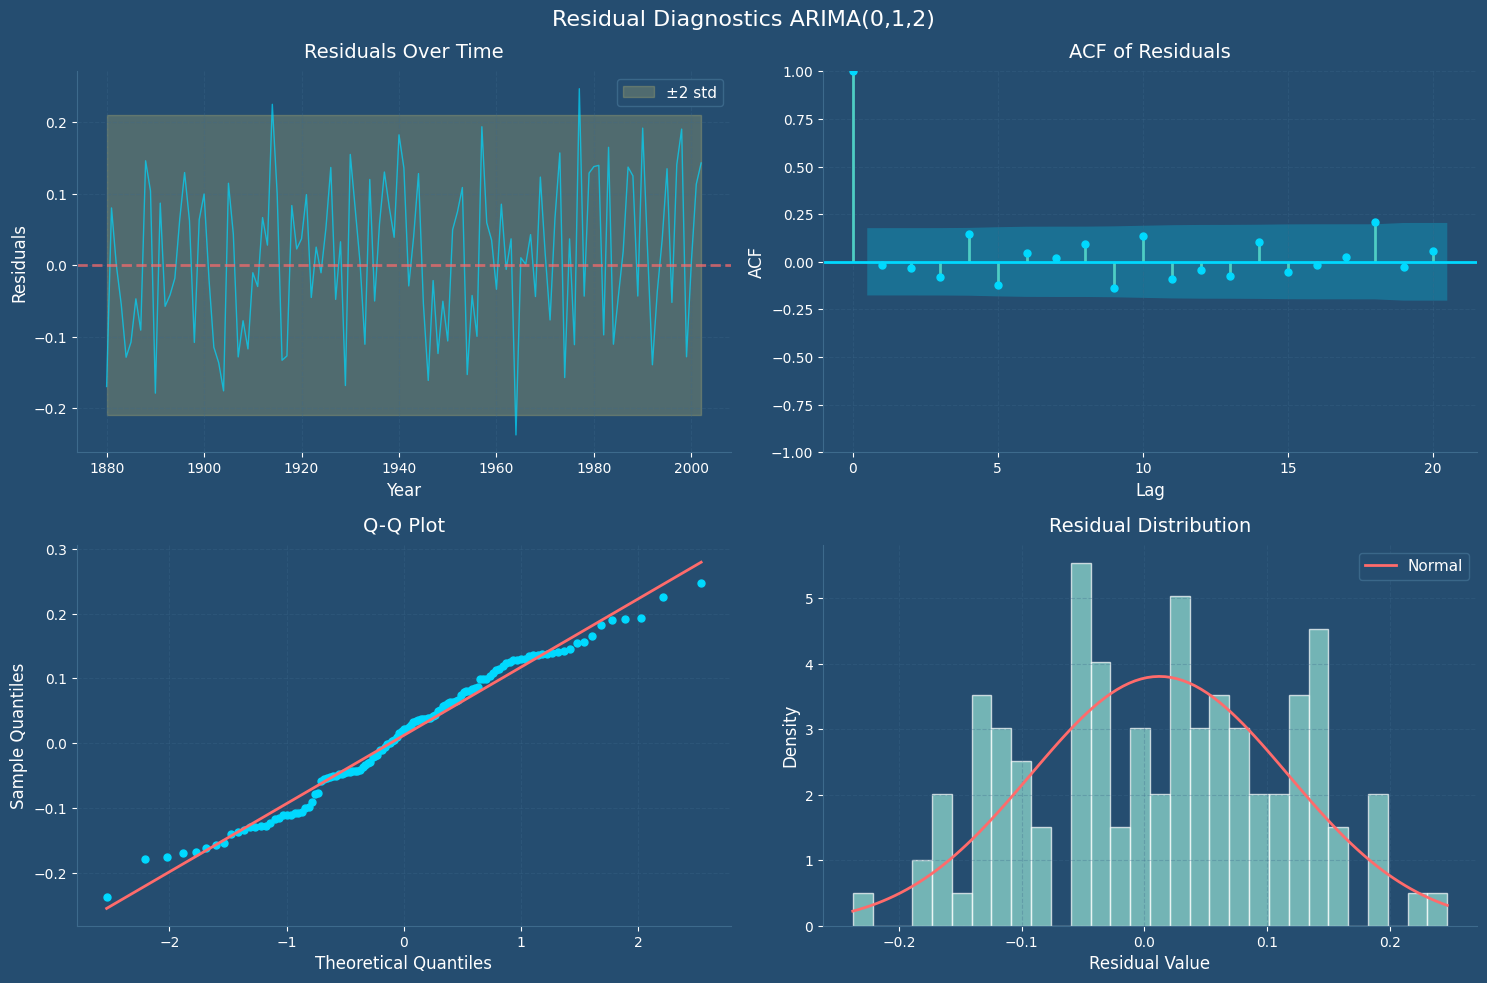


Statistical Tests:

Ljung-Box Test (H0: residuals are white noise):
  Lag 5  - statistic: 5.63, p-value: 0.3434
  Lag 10 - statistic: 12.17, p-value: 0.2740

Normalit Test (H0: residuals are normal):
  Statistic: 3.55, p-value: 0.1691

Heteroscedasticity Check:
  Residual std (first half): 0.1012
  Residual std (second half): 0.1085


In [120]:
# residuals from the fitted model
model = ARIMA(train, order=(0,1,2))
fitted_model = model.fit()
residuals = fitted_model.resid

# diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.patch.set_facecolor('#254D70')

# residuals over time
ax = axes[0, 0]
ax.plot(residuals.index, residuals.values, color=COLORS['primary'], alpha=0.7, linewidth=1)
ax.axhline(y=0, color=COLORS['secondary'], linestyle='--', alpha=0.7)
ax.fill_between(residuals.index, -2*residuals.std(), 2*residuals.std(), 
                color=COLORS['accent2'], alpha=0.2, label='±2 std')
style_axis(ax, xlabel='Year', ylabel='Residuals', title='Residuals Over Time')
ax.legend()

# ACF of residuals
ax = axes[0, 1]
plot_acf(residuals, lags=20, ax=ax, alpha=0.05,
            color=COLORS['primary'], 
            vlines_kwargs={'colors': COLORS['accent1']})
ax.set_facecolor('#254D70')
style_axis(ax, xlabel='Lag', ylabel='ACF', title='ACF of Residuals')

# Q-Q plot
ax = axes[1, 0]
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[0].set_color(COLORS['primary'])
ax.get_lines()[0].set_markersize(5)
ax.get_lines()[1].set_color(COLORS['secondary'])
ax.get_lines()[1].set_linewidth(2)
ax.set_facecolor('#254D70')
style_axis(ax, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles', 
            title='Q-Q Plot')

# histogram of residuals
ax = axes[1, 1]
ax.hist(residuals, bins=30, color=COLORS['accent3'], alpha=0.7, 
        edgecolor=COLORS['text'], density=True)

# normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
ax.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 
        color=COLORS['secondary'], linewidth=2, label='Normal')
style_axis(ax, xlabel='Residual Value', ylabel='Density', 
            title='Residual Distribution')
ax.legend()

plt.suptitle(f'Residual Diagnostics ARIMA(0,1,2)', fontsize=16, color=COLORS['text'])
plt.tight_layout()
plt.show()

# statistical tests
print("\nStatistical Tests:")

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\nLjung-Box Test (H0: residuals are white noise):")
print(f"  Lag 5  - statistic: {lb_test.iloc[4]['lb_stat']:.2f}, p-value: {lb_test.iloc[4]['lb_pvalue']:.4f}")
print(f"  Lag 10 - statistic: {lb_test.iloc[9]['lb_stat']:.2f}, p-value: {lb_test.iloc[9]['lb_pvalue']:.4f}")

# normality test
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nNormalit Test (H0: residuals are normal):")
print(f"  Statistic: {jb_stat:.2f}, p-value: {jb_pvalue:.4f}")

# heteroscedasticity check
print(f"\nHeteroscedasticity Check:")
print(f"  Residual std (first half): {residuals[:len(residuals)//2].std():.4f}")
print(f"  Residual std (second half): {residuals[len(residuals)//2:].std():.4f}")


Test Set Performance:
  MAE:  0.2792
  RMSE: 0.3435
  MAPE: 31.02%


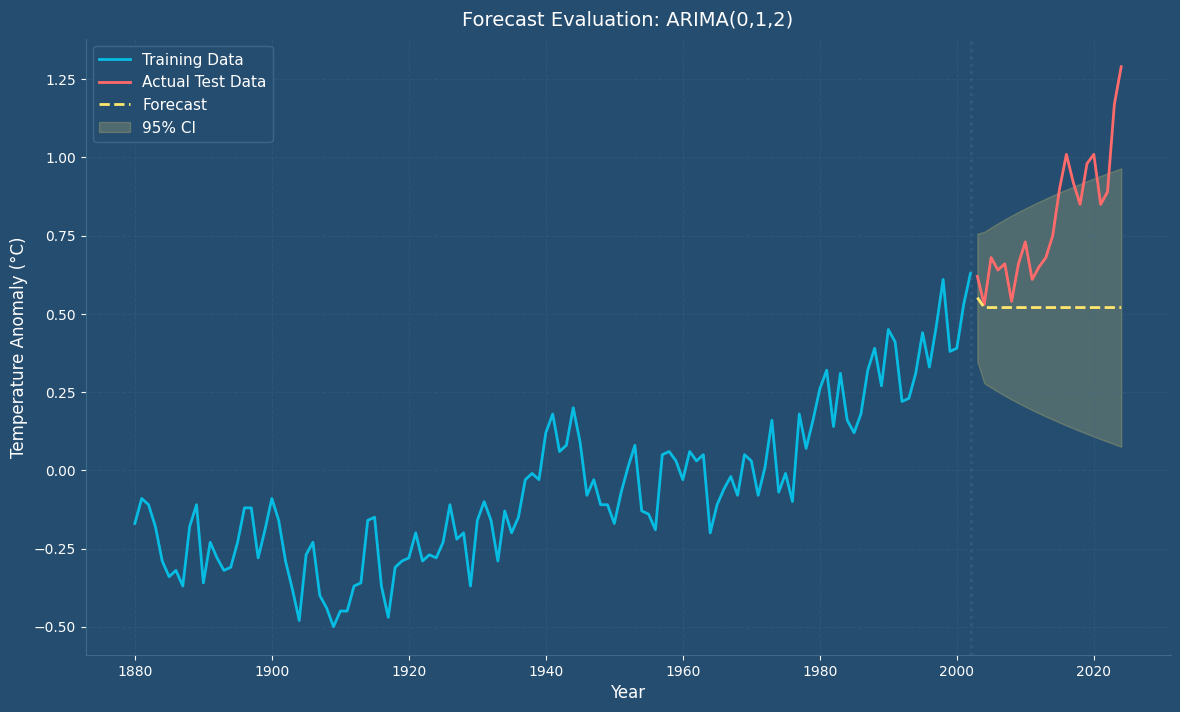

In [121]:
# generate forecasts
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

# test set metrics
test_mae = np.mean(np.abs(test.values - forecast))
test_rmse = np.sqrt(np.mean((test.values - forecast)**2))
test_mape = np.mean(np.abs((test.values - forecast) / test.values)) * 100

print(f"\nTest Set Performance:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

# forecast vs actual
fig, ax = create_custom_figure(figsize=(14, 8))

# training data
ax.plot(train.index, train.values, color=COLORS['primary'], 
        linewidth=2, label='Training Data', alpha=0.8)

# test data
ax.plot(test.index, test.values, color=COLORS['secondary'], 
        linewidth=2, label='Actual Test Data')

# forecast
ax.plot(test.index, forecast, color=COLORS['accent2'], 
        linewidth=2, linestyle='--', label='Forecast')

# confidence intervals
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
conf_int = forecast_result.conf_int(alpha=0.05)

ax.fill_between(test.index, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color=COLORS['accent2'], alpha=0.2, label='95% CI')

style_axis(ax, xlabel='Year', ylabel='Temperature Anomaly (°C)', 
            title=f'Forecast Evaluation: ARIMA(0,1,2)')
ax.legend()
ax.axvline(x=train.index[-1], color=COLORS['grid'], linestyle=':', alpha=0.5)

plt.show()

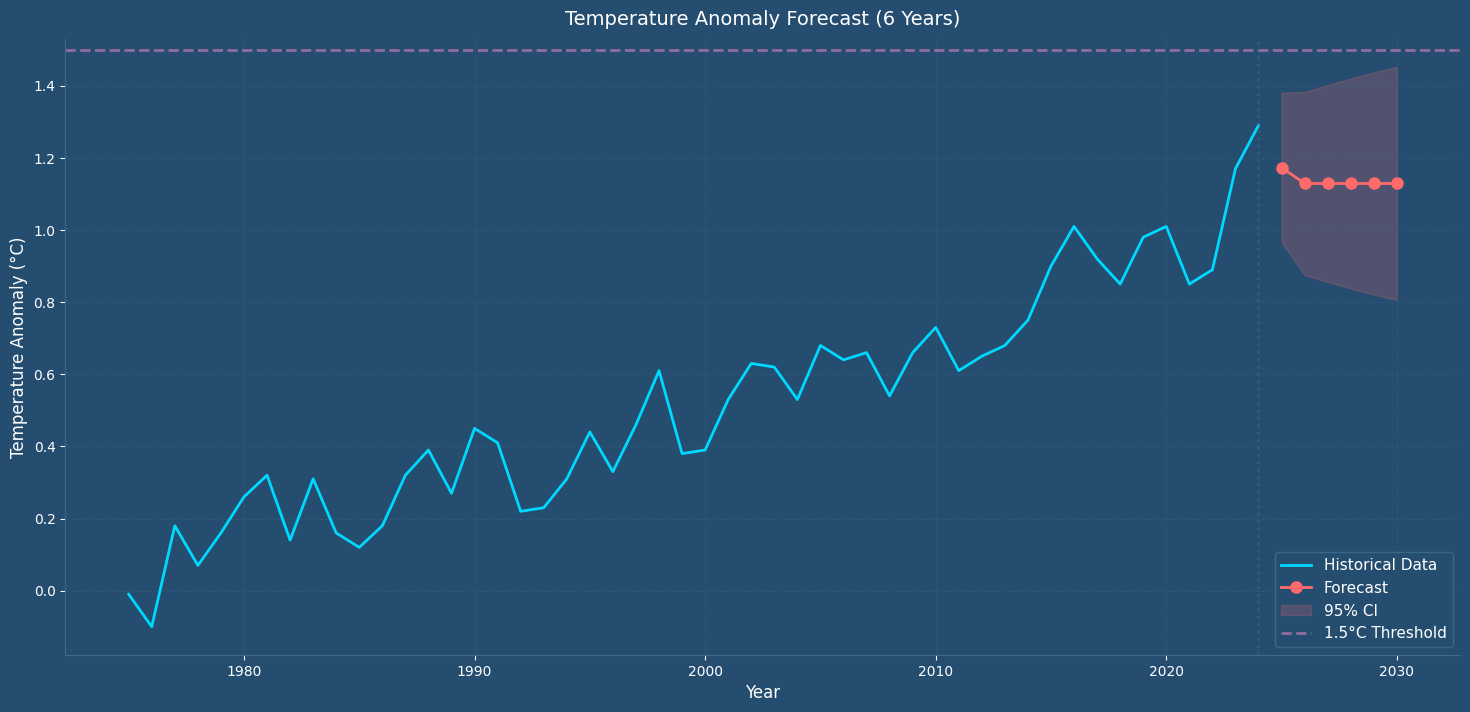


Forecast Summary (Next 6 Years):
  2025: 1.173°C (95% CI: 0.965 to 1.381)
  2026: 1.129°C (95% CI: 0.875 to 1.383)
  2027: 1.129°C (95% CI: 0.856 to 1.402)
  2028: 1.129°C (95% CI: 0.838 to 1.420)
  2029: 1.129°C (95% CI: 0.821 to 1.437)
  2030: 1.129°C (95% CI: 0.805 to 1.453)


In [ ]:
# ft model on entire dataset
model = ARIMA(ts, order=(0,1,2))
fitted_model = model.fit()
forecast_horizon = 6

# forecast
forecast = fitted_model.forecast(steps=forecast_horizon)
forecast_result = fitted_model.get_forecast(steps=forecast_horizon)
conf_int = forecast_result.conf_int(alpha=0.05)

# forecast dates
last_date = ts.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(years=1), 
                                periods=forecast_horizon, freq='YS')

fig, ax = create_custom_figure(figsize=(18, 8))

# historical data (last 50 years)
recent_years = 50
ax.plot(ts.index[-recent_years:], ts.values[-recent_years:], 
        color=COLORS['primary'], linewidth=2, label='Historical Data')

ax.plot(forecast_dates, forecast, color=COLORS['secondary'], 
        linewidth=2, marker='o', markersize=8, label='Forecast')

# confidence intervals
ax.fill_between(forecast_dates, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color=COLORS['secondary'], alpha=0.2, label='95% CI')

ax.axhline(y=1.5, color=COLORS['accent4'], linestyle='--', alpha=0.5, 
            label='1.5°C Threshold')
ax.axvline(x=ts.index[-1], color=COLORS['grid'], linestyle=':', alpha=0.5)

style_axis(ax, xlabel='Year', ylabel='Temperature Anomaly (°C)', 
            title=f'Temperature Anomaly Forecast ({forecast_horizon} Years)')
ax.legend()
plt.show()

# forecast summary
print(f"\nForecast Summary (Next {forecast_horizon} Years):")
for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
    lower = conf_int.iloc[i, 0]
    upper = conf_int.iloc[i, 1]
    print(f"  {date.year}: {value:.3f}°C (95% CI: {lower:.3f} to {upper:.3f})")